In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 설치 & model import

In [4]:
!pip3 install torch
!pip3 install torchvision
!pip3 install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 5.0 MB/s 
     |████████████████████████████████| 125 kB 86.0 MB/s 
     |████████████████████████████████| 512 kB 75.5 MB/s 
     |████████████████████████████████| 87 kB 8.8 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=b5ba826eff2badfa2cb4eafff5d2247a58d5e3757995d89a13d2cf4dcc88e295
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built fire


In [5]:
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 5.1 MB/s 
     |████████████████████████████████| 308 kB 44.0 MB/s 
     |████████████████████████████████| 33.8 MB 1.2 MB/s 
     |████████████████████████████████| 209 kB 99.0 MB/s 
     |████████████████████████████████| 81 kB 11.6 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 147 kB 72.3 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 112 kB 58.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=bd4a926219b8bee89e1a9f3ccff56b041bceecb248e9d8695666958a31f63bfa
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling s

In [6]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import os

In [7]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE
#from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters --> 버전오류. 자세한건 param tuning code 참조

In [8]:
from pytorch_forecasting.metrics import MultiHorizonMetric
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

class TweedieLoss(MultiHorizonMetric):
    """
    Tweedie loss.

    Tweedie regression with log-link. It might be useful, e.g., for modeling total
    loss in insurance, or for any target that might be tweedie-distributed.

    The loss will take the exponential of the network output before it is returned as prediction.
    Target normalizer should therefore have no "reverse" transformation, e.g.
    for the :py:class:`~data.timeseries.TimeSeriesDataSet` initialization, one could use:

    .. code-block:: python

        from pytorch_forecasting import TimeSeriesDataSet, EncoderNormalizer

        dataset = TimeSeriesDataSet(
            target_normalizer=EncoderNormalizer(transformation=dict(forward=torch.log1p))
        )

    Note that in this example, the data is log1p-transformed before normalized but not re-transformed.
    The TweedieLoss applies this "exp"-re-transformation on the network output after it has been de-normalized.
    The result is the model prediction.
    """

    def __init__(self, reduction="mean", p: float = 1.5, **kwargs):
        """
        Args:
            p (float, optional): tweedie variance power which is greater equal
                1.0 and smaller 2.0. Close to ``2`` shifts to
                Gamma distribution and close to ``1`` shifts to Poisson distribution.
                Defaults to 1.5.
            reduction (str, optional): How to reduce the loss. Defaults to "mean".
        """
        super().__init__(reduction=reduction, **kwargs)
        assert 1 <= p < 2, "p must be in range [1, 2]"
        self.p = p

    def to_prediction(self, out: Dict[str, torch.Tensor]):
        rate = torch.exp(super().to_prediction(out))
        return rate


    def loss(self, y_pred, y_true):
        y_pred = super().to_prediction(y_pred)
        a = y_true * torch.exp(y_pred * (1 - self.p)) / (1 - self.p)
        b = torch.exp(y_pred * (2 - self.p)) / (2 - self.p)
        loss = -a + b
        return loss


In [9]:
import tensorflow as tf
import tensorboard as tb
import gc


### Load data

In [10]:
os.chdir("/content/drive/MyDrive/소캡디/code")

In [11]:
data = pd.read_pickle("./data_use/CA_1_final_grid_df.pkl")

### 데이터 추가정제

In [12]:
data.dropna(subset=['sales'],inplace=True) #test data 삭제
data = data.reset_index(drop=True)

data = data.drop(columns = ['id','store_id','state_id'])

values = {"rolling_mean_7": 0, "rolling_mean_14": 0, "rolling_mean_30": 0, "rolling_mean_60":0, "rolling_mean_180":0,
          "rolling_std_7":0,"rolling_std_14":0, "rolling_std_30":0, "rolling_std_60":0,"rolling_std_180":0}
data.fillna(values, inplace=True)
data["log_sales"] = np.log(data.sales + 0.0001)

In [13]:
"""
data["rolling_mean_7"] = np.log(data.rolling_mean_7+1)
data["rolling_mean_14"] = np.log(data.rolling_mean_14+1)
data["rolling_mean_30"] = np.log(data.rolling_mean_30+1)
data["rolling_mean_60"] = np.log(data.rolling_mean_60+1)
data["rolling_mean_180"] = np.log(data.rolling_mean_180+1)
data["rolling_std_7"] = np.log(data.rolling_std_7+1)
data["rolling_std_14"] = np.log(data.rolling_std_14+1)
data["rolling_std_30"] = np.log(data.rolling_std_30+1)
data["rolling_std_60"] = np.log(data.rolling_std_60+1)
data["rolling_std_180"] = np.log(data.rolling_std_180+1)
data["enc_cat_id_mean"] = np.log(data.enc_cat_id_mean+1)
data["enc_dept_id_mean"] = np.log(data.enc_dept_id_mean+1)
data["enc_item_id_mean"] = np.log(data.enc_item_id_mean+1)
data["enc_cat_id_std"] = np.log(data.enc_cat_id_std+1)
data["enc_dept_id_std"] = np.log(data.enc_dept_id_std+1)
data["enc_item_id_std"] = np.log(data.enc_item_id_std+1)
"""

'\ndata["rolling_mean_7"] = np.log(data.rolling_mean_7+1)\ndata["rolling_mean_14"] = np.log(data.rolling_mean_14+1)\ndata["rolling_mean_30"] = np.log(data.rolling_mean_30+1)\ndata["rolling_mean_60"] = np.log(data.rolling_mean_60+1)\ndata["rolling_mean_180"] = np.log(data.rolling_mean_180+1)\ndata["rolling_std_7"] = np.log(data.rolling_std_7+1)\ndata["rolling_std_14"] = np.log(data.rolling_std_14+1)\ndata["rolling_std_30"] = np.log(data.rolling_std_30+1)\ndata["rolling_std_60"] = np.log(data.rolling_std_60+1)\ndata["rolling_std_180"] = np.log(data.rolling_std_180+1)\ndata["enc_cat_id_mean"] = np.log(data.enc_cat_id_mean+1)\ndata["enc_dept_id_mean"] = np.log(data.enc_dept_id_mean+1)\ndata["enc_item_id_mean"] = np.log(data.enc_item_id_mean+1)\ndata["enc_cat_id_std"] = np.log(data.enc_cat_id_std+1)\ndata["enc_dept_id_std"] = np.log(data.enc_dept_id_std+1)\ndata["enc_item_id_std"] = np.log(data.enc_item_id_std+1)\n'

### department별 분류

In [1]:
dept_data_arr = []

In [14]:
department = data["dept_id"].unique()

for d in department:
  dept_data = data[data["dept_id"]== d]
  dept_data = dept_data.drop(columns = ['cat_id','enc_cat_id_std','enc_cat_id_mean','dept_id','enc_dept_id_std','enc_dept_id_mean'])
  dept_data_arr.append(dept_data)

### Training

In [27]:
dataloader_arr= []
trainer_arr = []
model_arr = []

max_prediction_length = 28  
max_encoder_length = 90 
training_cutoff = data["d"].max() - max_prediction_length 
batch_size = 32

In [ ]:
for dept_data in dept_data_arr:
  training = TimeSeriesDataSet(
      dept_data[lambda x: x["d"] <= training_cutoff],
      time_idx="d",
      target="sales",
      group_ids=["item_id"],
      min_encoder_length= 1,
      max_encoder_length= max_encoder_length,
      min_prediction_length= 1,
      max_prediction_length=max_prediction_length,
      static_categoricals=["item_id"],
      static_reals=["release","price_max","price_min","price_std","price_mean","price_nunique","enc_item_id_mean", "enc_item_id_std"], 
      time_varying_known_categoricals=["snap_CA", "snap_TX","snap_WI","tm_w_end","event_name_1","event_name_2","event_type_1","event_type_2"], 
      time_varying_known_reals=["d","tm_d","tm_w",'tm_m',"tm_y","tm_wm","tm_dw","sell_price","price_norm","price_momentum","price_momentum_m","price_momentum_y",
                                "rolling_mean_7", "rolling_mean_14", "rolling_mean_30", "rolling_mean_60", "rolling_mean_180",
                                "rolling_std_7","rolling_std_14", "rolling_std_30", "rolling_std_60","rolling_std_180"],
      time_varying_unknown_categoricals=[],
      time_varying_unknown_reals=["sales","log_sales"],
      add_relative_time_idx=True,
      add_target_scales=True,
      add_encoder_length=True,
    )
  
  validation = TimeSeriesDataSet.from_dataset(training, dept_data, predict=True, stop_randomization=True)
  train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
  val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)
  dataloader_arr.append([train_dataloader,val_dataloader])

  early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
  lr_logger = LearningRateMonitor()  # log the learning rate
  logger = TensorBoardLogger("lightning_logs_ver5")  # logging results to a tensorboard

  trainer = pl.Trainer(
      max_epochs=30,
      gpus=1,
      enable_model_summary=True,
      gradient_clip_val=0.1,
      limit_train_batches=30, 
      callbacks=[lr_logger,early_stop_callback],
      logger=logger,
    )
  trainer_arr.append(trainer)

  tft = TemporalFusionTransformer.from_dataset(
      training,
      learning_rate=0.001,
      hidden_size=80, #state size가 이거일까...?
      attention_head_size=4,
      dropout=0.1,
      hidden_continuous_size=16,
      output_size=1,  # point로 바꿔서 1로 변경
      loss= TweedieLoss(),
      log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
      reduce_on_plateau_patience=4,
  )
  model_arr.append(tft)

In [29]:
# 모델 training
for i in range(7):
  tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
  gc.collect()
  torch.cuda.empty_cache()

  trainer_arr[i].fit(
      model_arr[i],
      train_dataloaders=dataloader_arr[i][0],
      val_dataloaders=dataloader_arr[i][1],
  )

  best_model_path = trainer_arr[i].checkpoint_callback.best_model_path
  best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

  #모델 저장
  torch.save(best_tft.state_dict(),'./model_build/tft_best_model_1203_dept'+str(i)+'.pt')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | TweedieLoss                     | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 19.9 K
3  | prescalers                         | ModuleDict                      | 1.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 44.1 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 114 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 104 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 26.1 K
8  | static_context_initial_hidde

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | TweedieLoss                     | 0     
1  | logging_m

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | TweedieLoss                     | 0     
1  | logging_m

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | l

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | l

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | TweedieLoss                     | 0     
1  | logging_m

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | l

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


__________________

### 모델 확인

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(1.5452)

In [ ]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

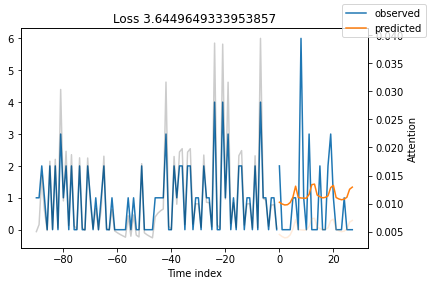

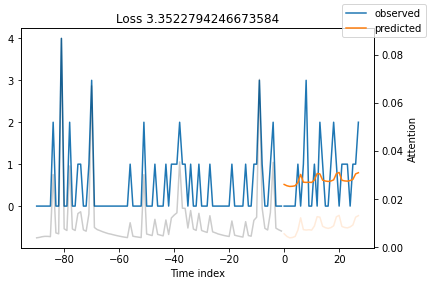

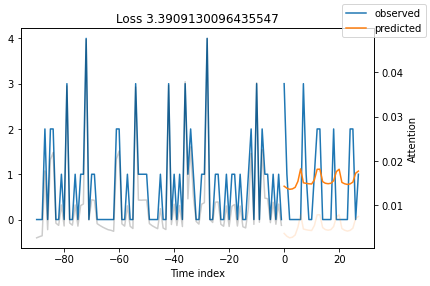

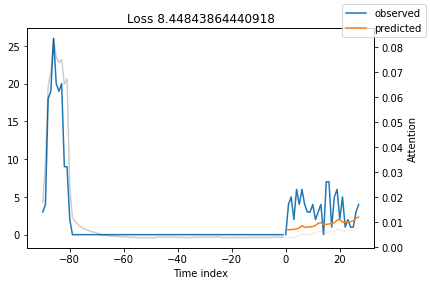

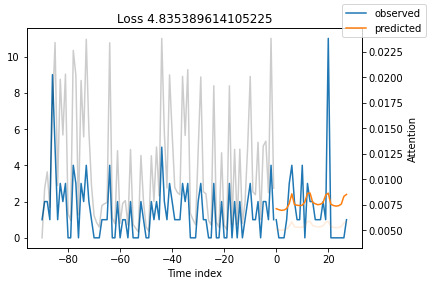

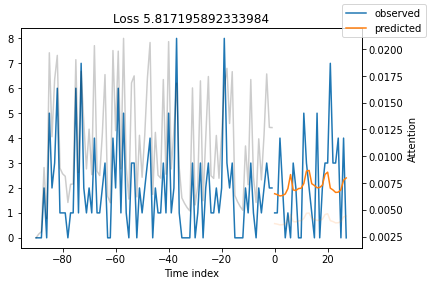

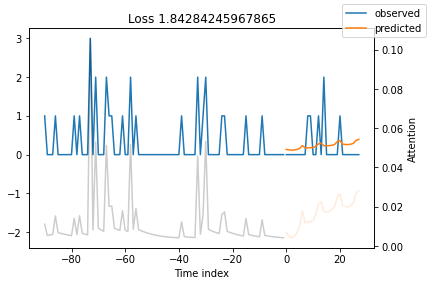

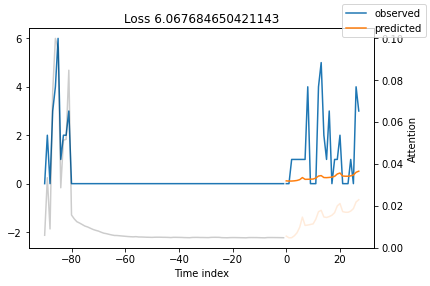

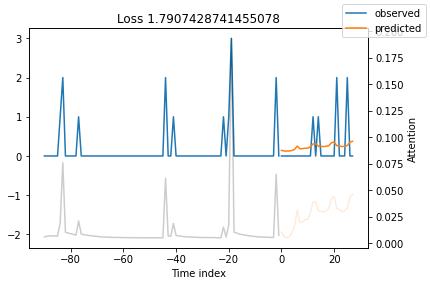

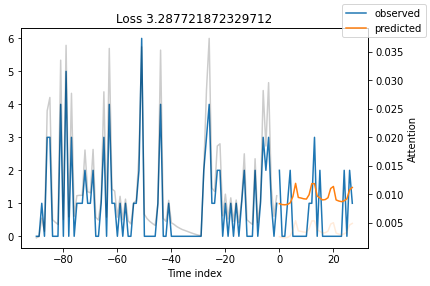

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/models/base_mo

{'release': <Figure size 720x360 with 2 Axes>,
 'price_max': <Figure size 720x360 with 2 Axes>,
 'price_min': <Figure size 720x360 with 2 Axes>,
 'price_std': <Figure size 720x360 with 2 Axes>,
 'price_mean': <Figure size 720x360 with 2 Axes>,
 'price_nunique': <Figure size 720x360 with 2 Axes>,
 'enc_dept_id_mean': <Figure size 720x360 with 2 Axes>,
 'enc_dept_id_std': <Figure size 720x360 with 2 Axes>,
 'enc_item_id_mean': <Figure size 720x360 with 2 Axes>,
 'enc_item_id_std': <Figure size 720x360 with 2 Axes>,
 'encoder_length': <Figure size 720x360 with 2 Axes>,
 'sales_center': <Figure size 720x360 with 2 Axes>,
 'sales_scale': <Figure size 720x360 with 2 Axes>,
 'd': <Figure size 720x360 with 2 Axes>,
 'tm_d': <Figure size 720x360 with 2 Axes>,
 'tm_w': <Figure size 720x360 with 2 Axes>,
 'tm_m': <Figure size 720x360 with 2 Axes>,
 'tm_y': <Figure size 720x360 with 2 Axes>,
 'tm_wm': <Figure size 720x360 with 2 Axes>,
 'tm_dw': <Figure size 720x360 with 2 Axes>,
 'sell_price': <F

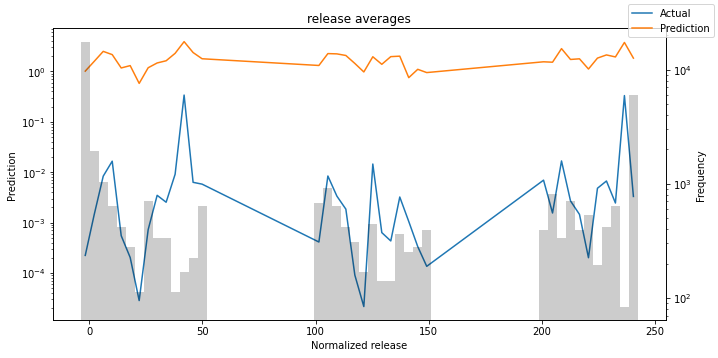

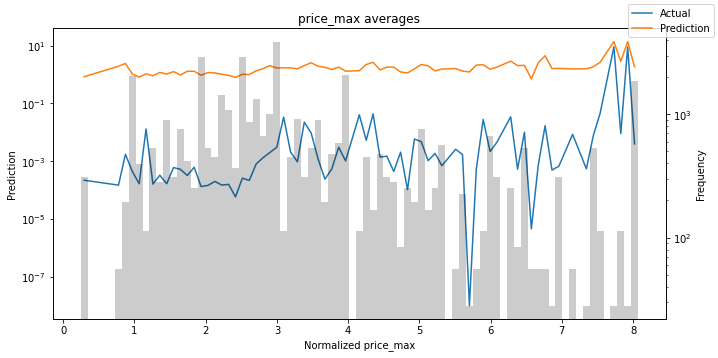

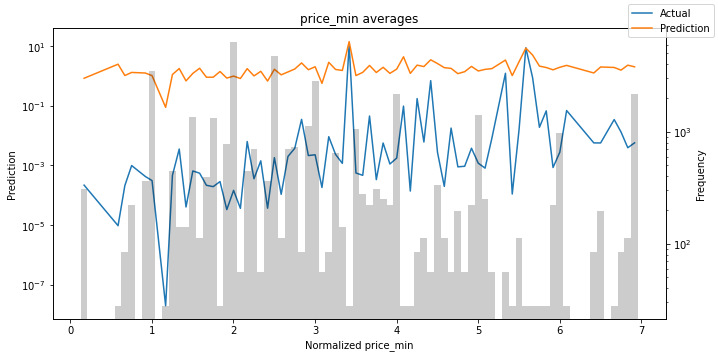

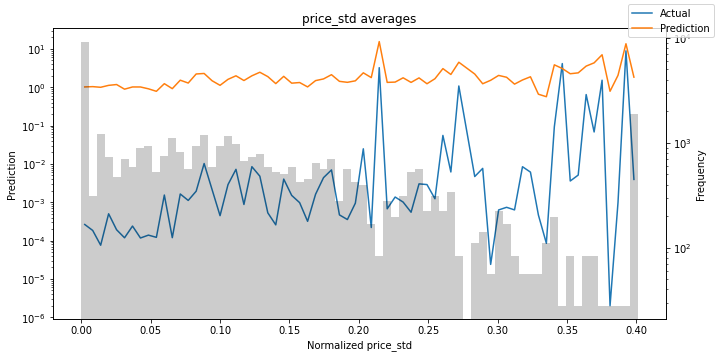

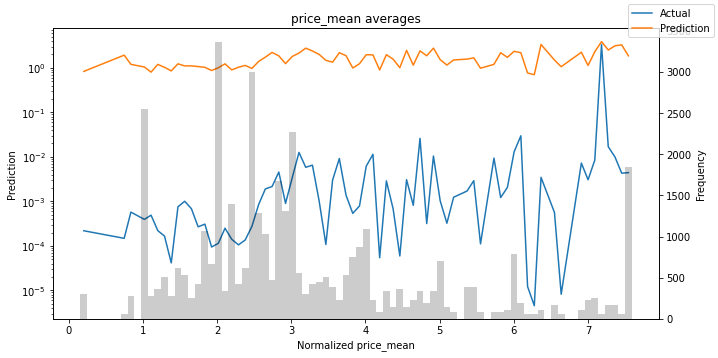

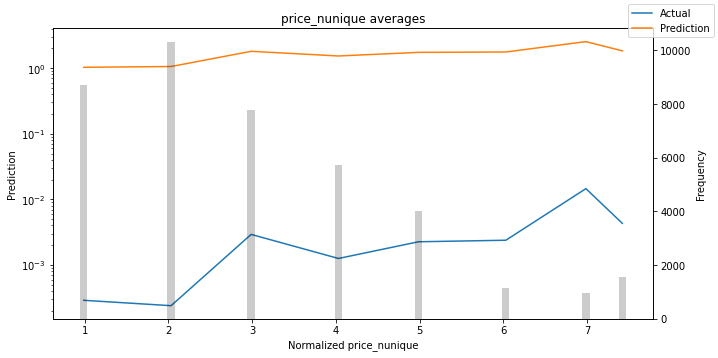

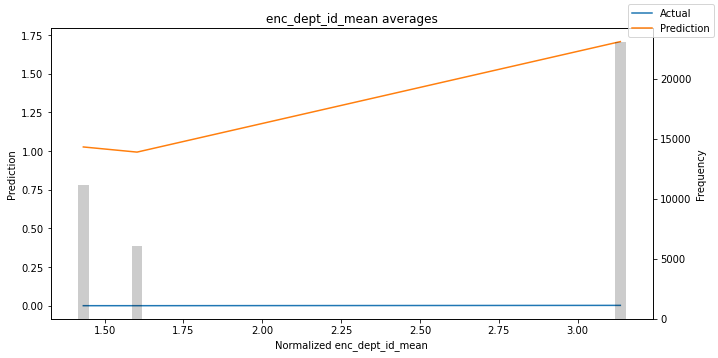

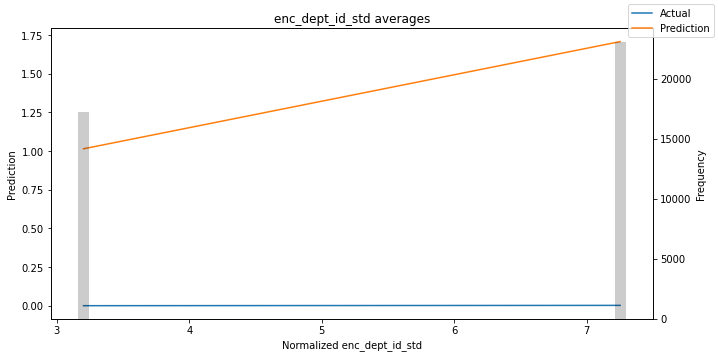

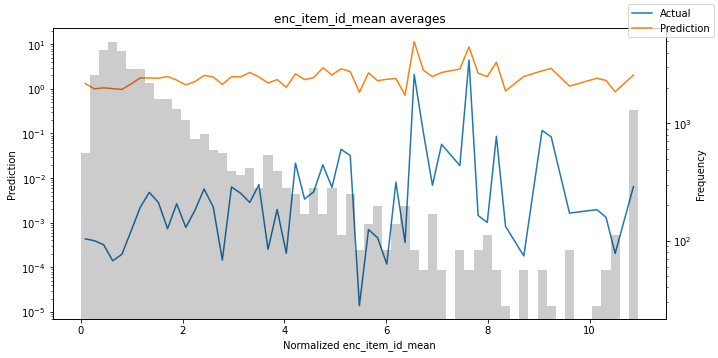

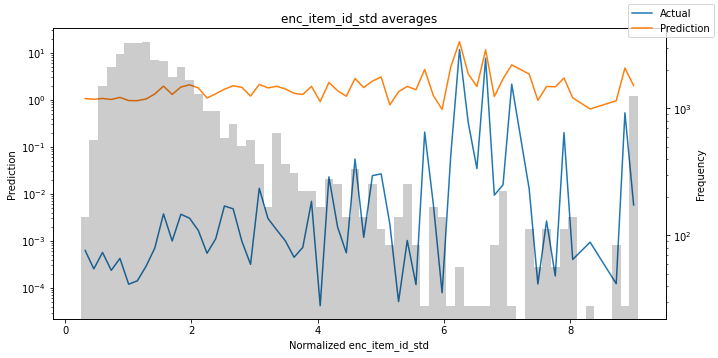

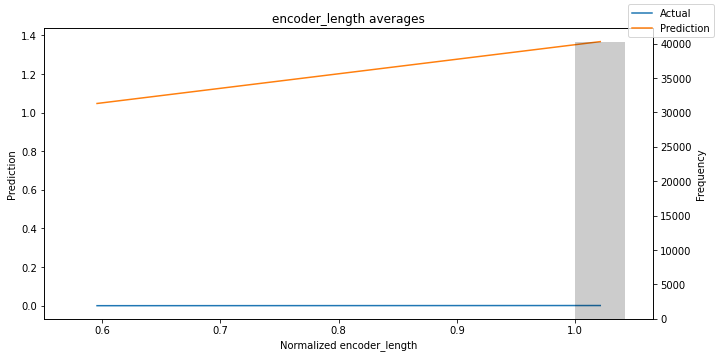

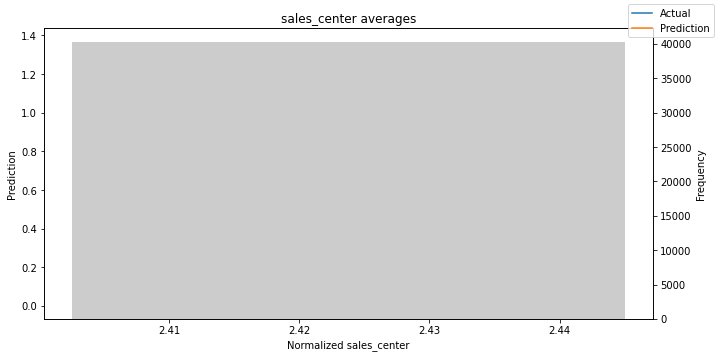

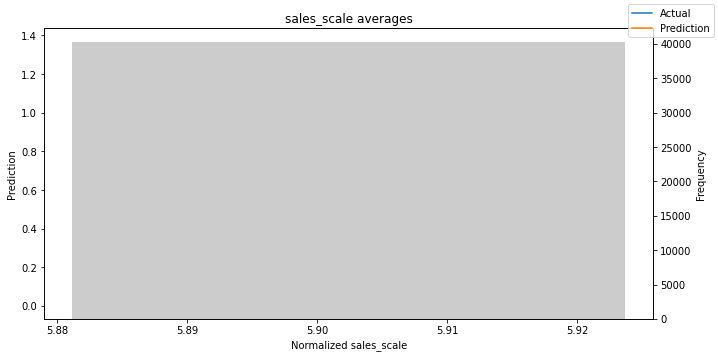

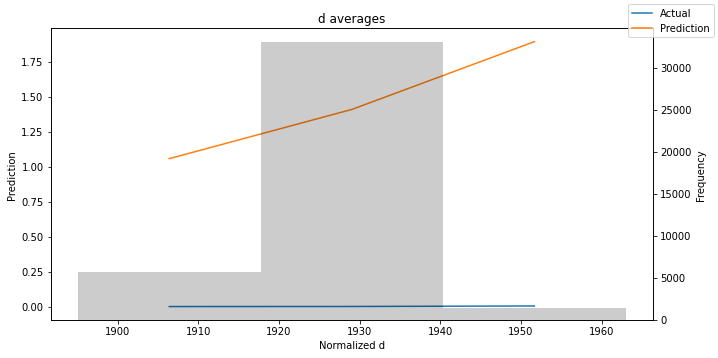

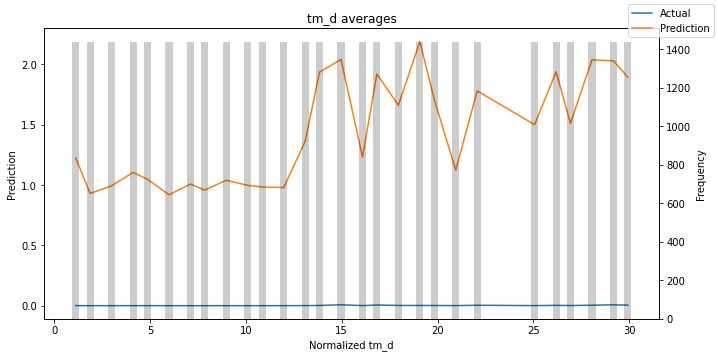

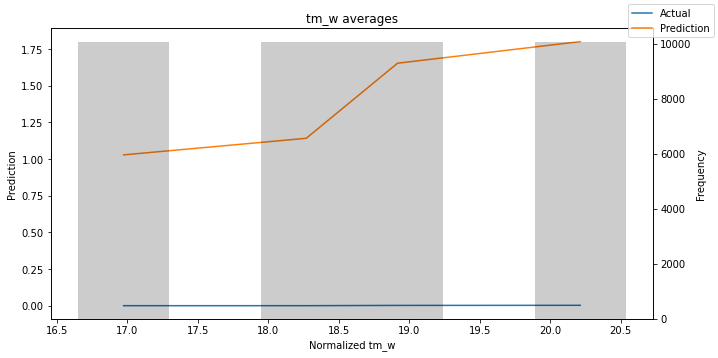

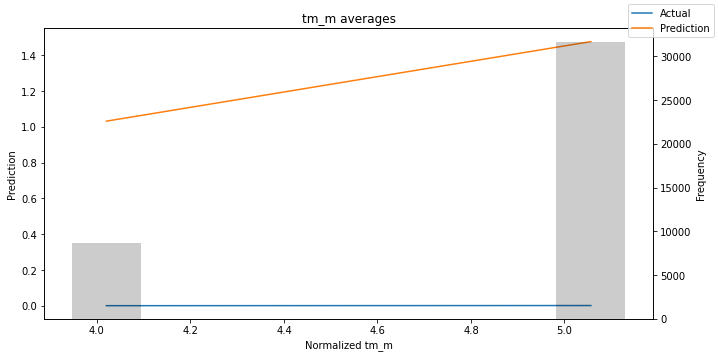

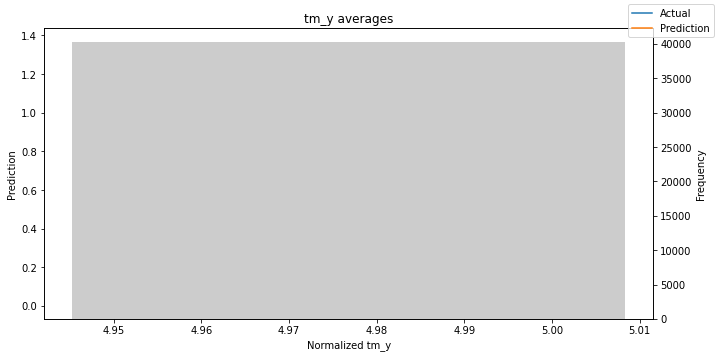

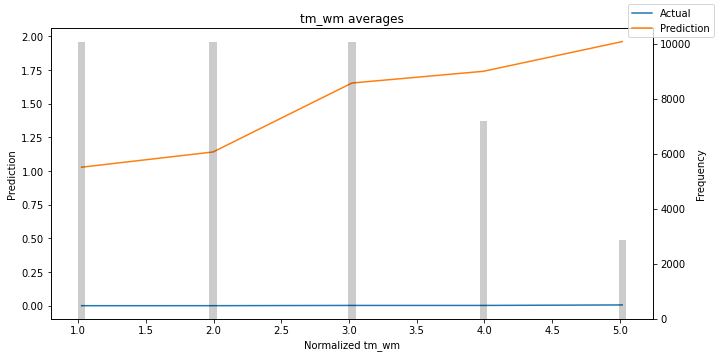

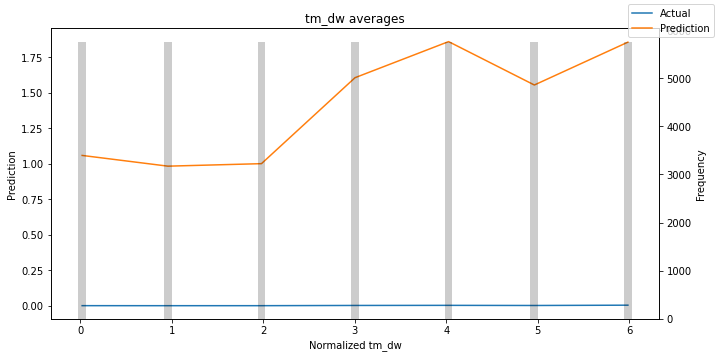

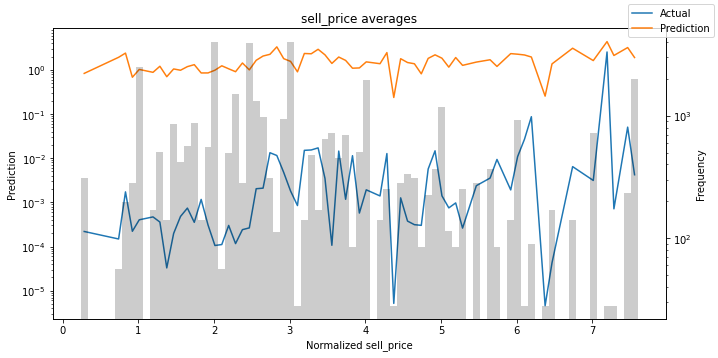

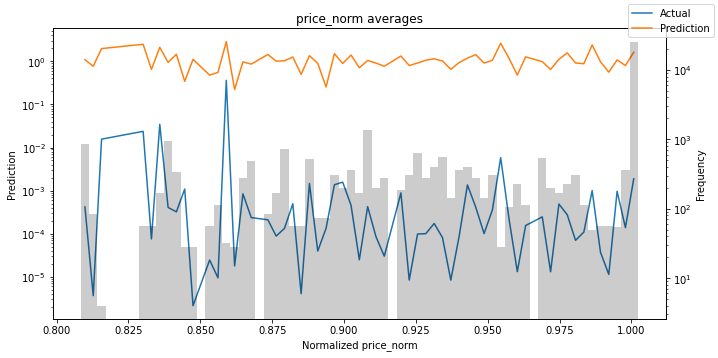

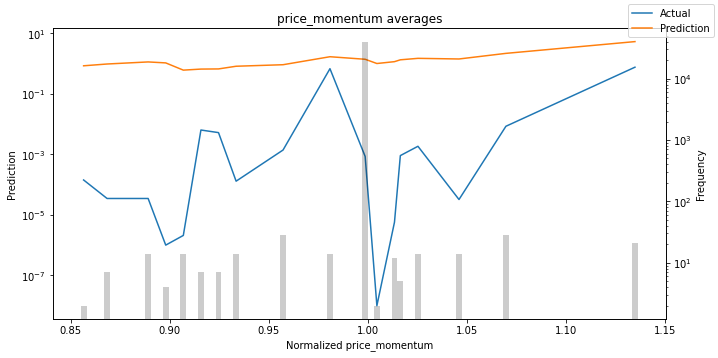

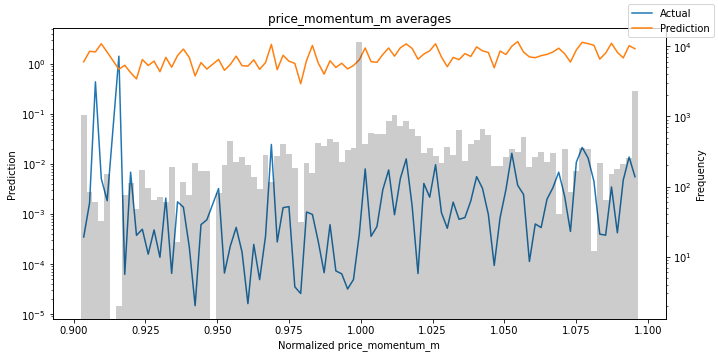

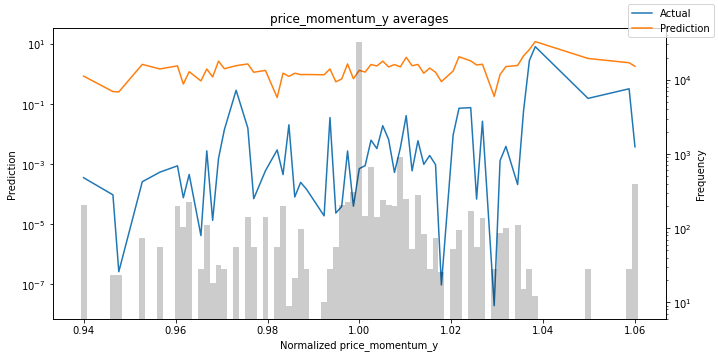

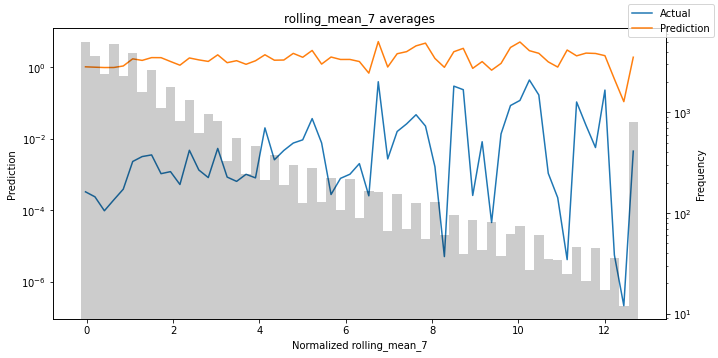

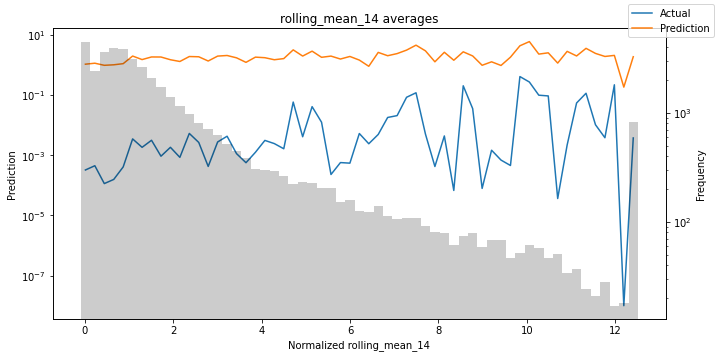

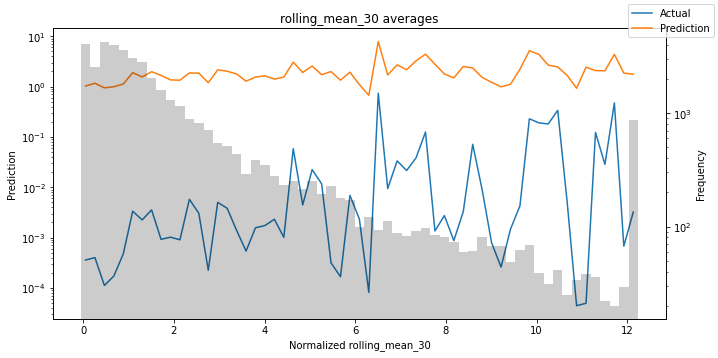

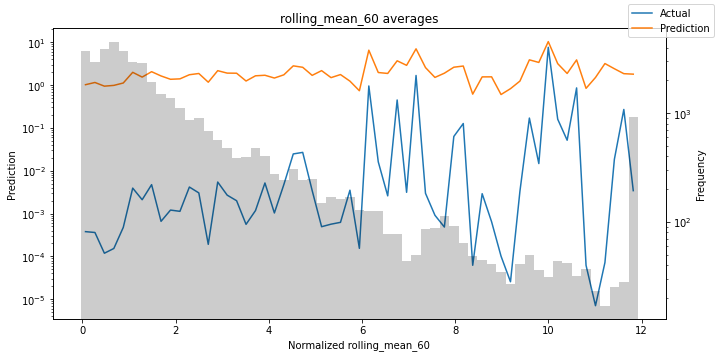

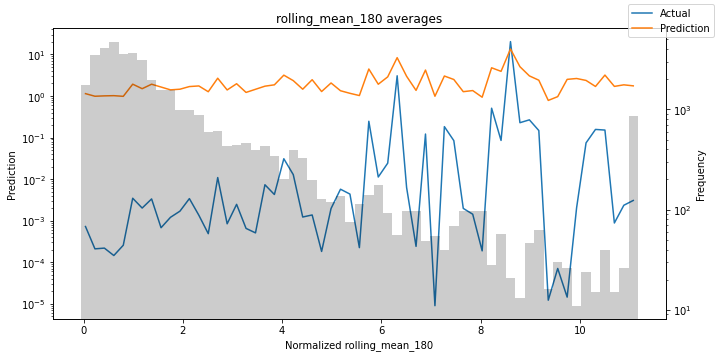

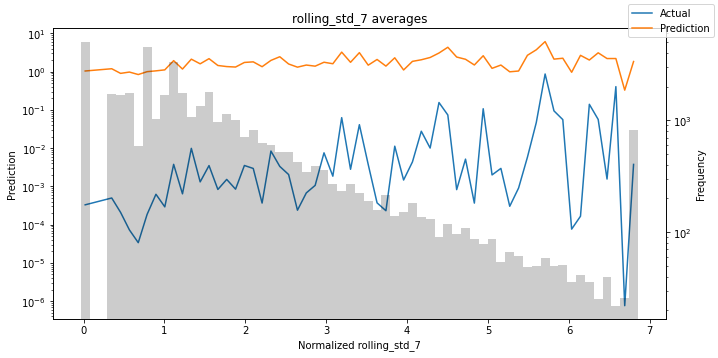

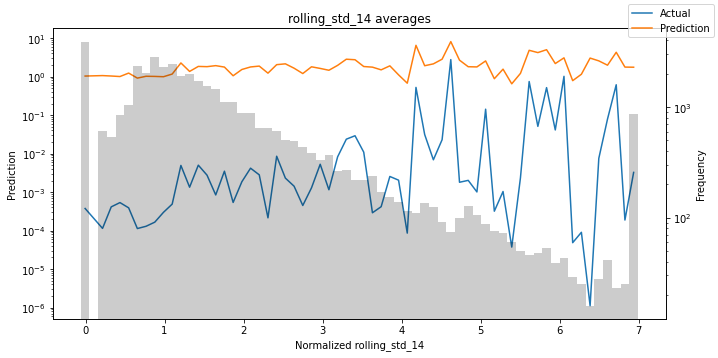

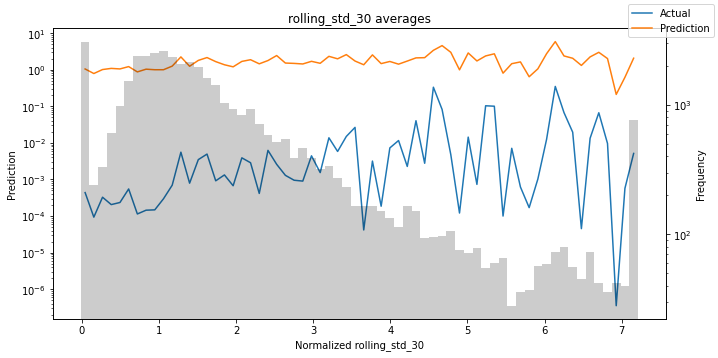

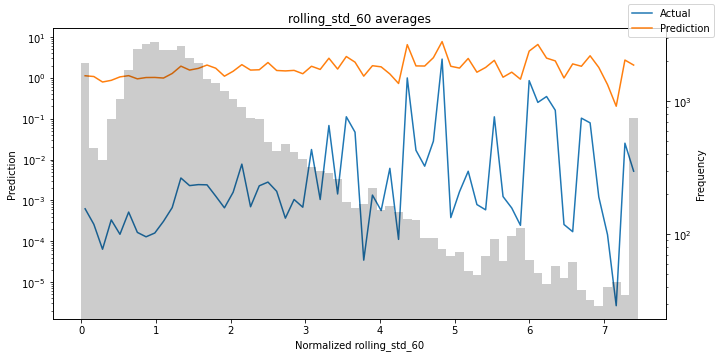

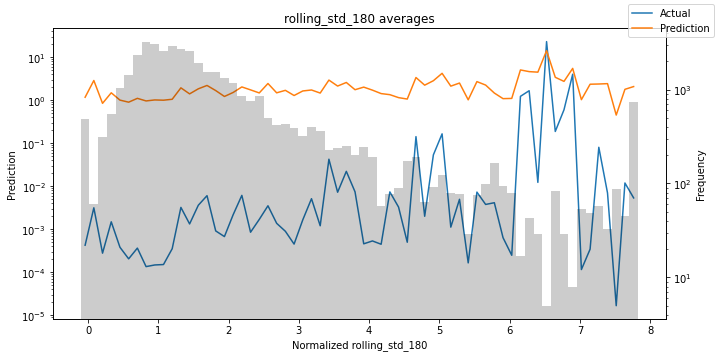

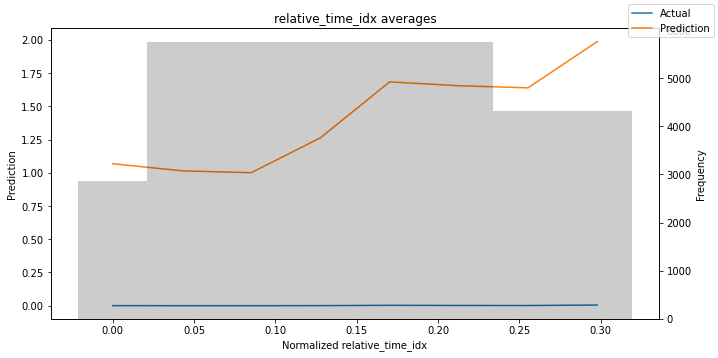

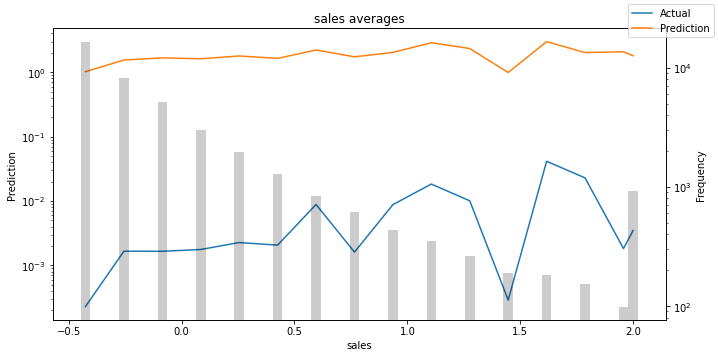

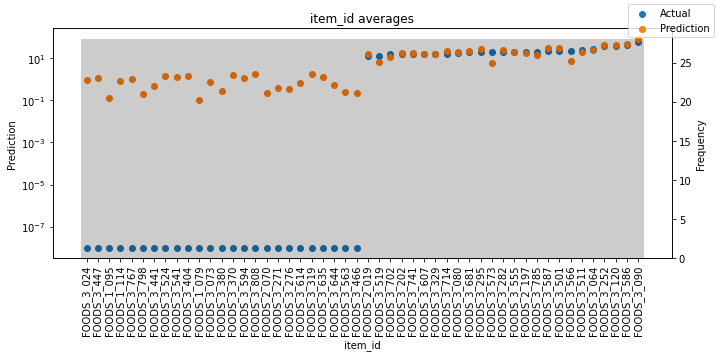

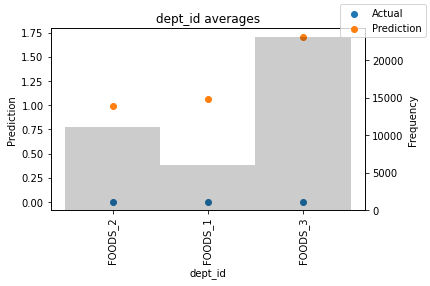

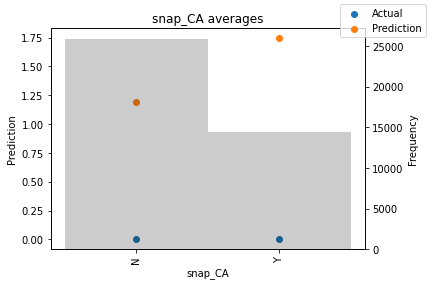

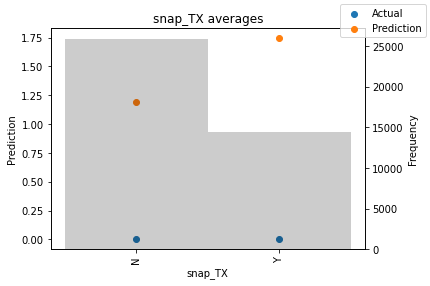

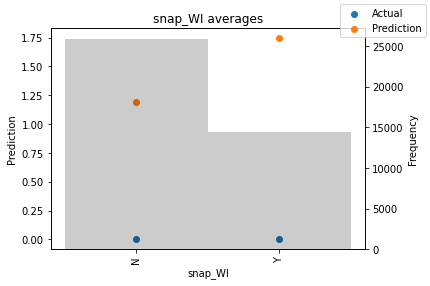

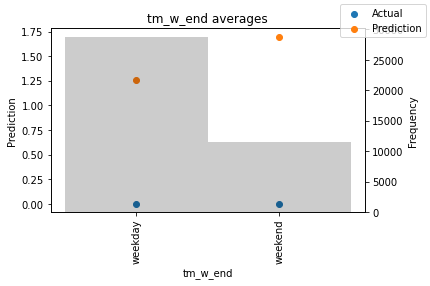

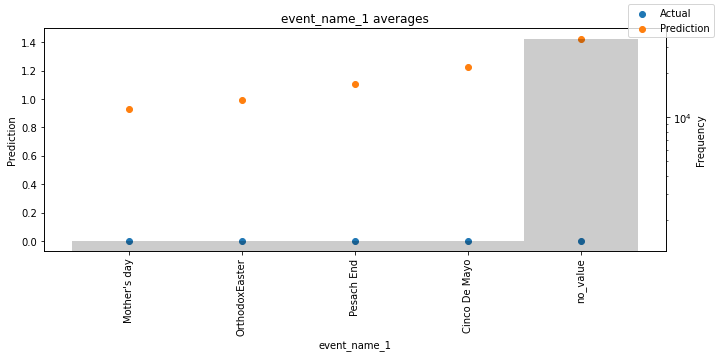

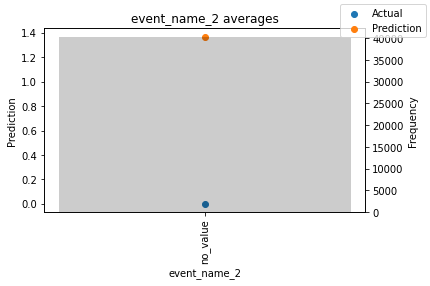

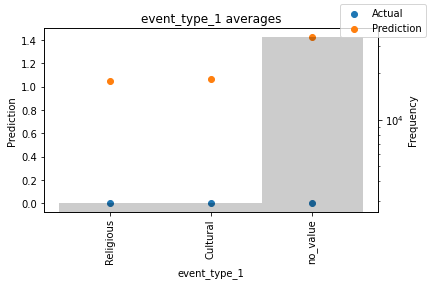

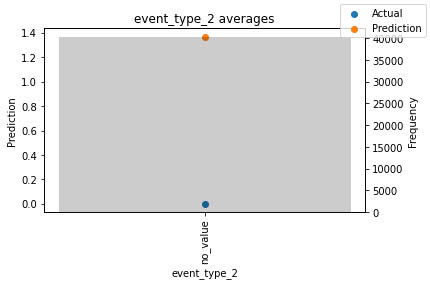

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs_ver5/

### 모델 로드

In [ ]:
loaded_model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160, #state size가 이거일까...?
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=80,
    output_size=7,  # point로 바꿔서 1로 변경
    loss= QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
loaded_model.load_state_dict(torch.load('./model_build/tft_best_model_1129.pt'))
loaded_model.eval()

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = loaded_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.3791)

In [ ]:
raw_predictions, x = loaded_model.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
for idx in range(10):  # plot 10 examples
    loaded_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);